# About Q-Learning algorithm
> "Q-learning is a model-free reinforcement learning algorithm. The goal of Q-learning is to learn a policy, which tells an agent what action to take under what circumstances. It does not require a model (hence the connotation "model-free") of the environment, and it can handle problems with stochastic transitions and rewards, without requiring adaptations."
[*wiki*](https://en.wikipedia.org/wiki/Q-learning)

In [4]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import matplotlib as mpl
import joblib
import os
import keras

import matplotlib.animation as animation
mpl.rc('animation', html='jshtml')

In [5]:
import gym

#### DQN부터 시작

In [ ]:
# 데이터셋 = cartpole
# !pip install numpy==1.19.5
keras.backend.clear_session()
env = gym.make("CartPole-v1")
env.seed(77)
input_shape = [4]
n_outputs = 2

In [7]:
env.observation_space.shape

(4,)

In [8]:
# 모델 정의
# 레이어 2층, 아웃풋 1층
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=input_shape),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                160       
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 dense_2 (Dense)             (None, 2)                 66        
                                                                 
Total params: 1,282
Trainable params: 1,282
Non-trainable params: 0
_________________________________________________________________


In [9]:
# 입실론 그리디 정책
# 최초 입실론 0
def epsilon_greedy_policy(state, epsilon=0):
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        Q_values = model.predict(state[np.newaxis])
        return np.argmax(Q_values[0])

In [10]:
# replay 메모리
from collections import deque

replay_memory = deque(maxlen=2000)

In [11]:
# 경험 샘플링 함수 정의
def sample_experiences(batch_size):
    indices = np.random.randint(len(replay_memory), size=batch_size)
    batch = [replay_memory[index] for index in indices]
    states, actions, rewards, next_states, dones = [
        np.array([experience[field_index] for experience in batch])
        for field_index in range(5)]
    return states, actions, rewards, next_states, dones

In [12]:
# 한 step 이동하는 함수 정의
def play_one_step(env, state, epsilon):
    action = epsilon_greedy_policy(state, epsilon)
    next_state, reward, done, info = env.step(action)
    replay_memory.append((state, action, reward, next_state, done))
    return next_state, reward, done, info

In [13]:
# 모델 정의
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate=1e-2)
loss_fn = keras.losses.mean_squared_error

In [16]:
# DQN 학습 - gradient descent 한 스텝씩 추가 함수
# 입실론, 그리디 policy, q-벨류 알고리즘, 자동미분 사용
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    max_next_Q_values = np.max(next_Q_values, axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * max_next_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        # states = tf.convert_to_tensor(states, dtype=tf.float32)
        # actions = np.array(actions)
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

In [ ]:
# 모델 학습
env.seed(1)
tf.random.set_seed(1)
rewards=[]
best_score=0
# observe 초기화부터 시작. 600회
for episode in range(300):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step) # Not shown in the book
    if step >= best_score: # Not shown
        best_weights = model.get_weights() # Not shown
        best_score = step # Not shown
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    if episode > 50:
      training_step(batch_size)
model.set_weights(best_weights)

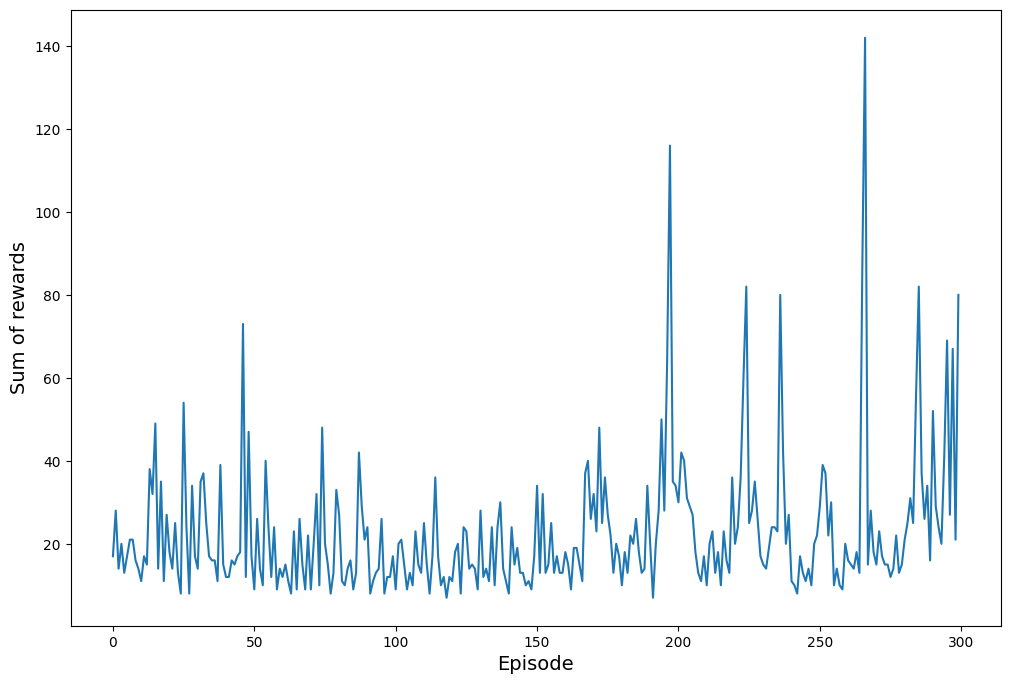

In [18]:
# 에피소드 반복에 따른 시각화
plt.figure(figsize=(12, 8))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.show()

In [ ]:
!pip install pyvirtualdisplay
try:
    import pyvirtualdisplay
    display = pyvirtualdisplay.Display(visible=0, size=(1400, 900, 24)).start()
except ImportError:
    pass

In [ ]:
# 파이썬 화면 가상환경
# import pyvirtualdisplay

In [ ]:
env.render()

In [21]:
# cart_pole 영상 시각화 함수 정의
frames=[]
obs = env.reset()
def update_scene(num, frames, patch):
  patch.set_data(frames[num])
  return patch,

def plot_animation(frames, repeat = False, interval=40):
  fig = plt.figure()
  patch = plt.imshow(frames[0])
  plt.axis('off')
  anim = animation.FuncAnimation(
      fig, update_scene, fargs=(frames, patch),
      frames = len(frames), repeat=repeat, interval = interval
  )
  plt.close()
  return anim

In [ ]:
# 행동 시 300 스텝
state = env.reset()

frames = []

for step in range(300):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

In [ ]:
# DQN 애니메이션 반출
plot_animation(frames)

#### Double DQN

In [24]:
# 상태 초기화
keras.backend.clear_session()
tf.random.set_seed(77)

In [25]:
# 모델 정의
model = keras.models.Sequential([
    keras.layers.Dense(32, activation="elu", input_shape=[4]),
    keras.layers.Dense(32, activation="elu"),
    keras.layers.Dense(n_outputs),
])
target = keras.models.clone_model(model)
target.set_weights(model.get_weights())

In [30]:
# 배치 사이즈, 할인율, 최적화, 손실함수
batch_size = 32
discount_rate = 0.95
optimizer = keras.optimizers.Adam(learning_rate = 0.006)
loss_fn = keras.losses.Huber()
# gradient descent 한 스텝씩 추가 함수
def training_step(batch_size):
    experiences = sample_experiences(batch_size)
    states, actions, rewards, next_states, dones = experiences
    next_Q_values = model.predict(next_states)
    best_next_actions = np.argmax(next_Q_values, axis=1)
    next_mask = tf.one_hot(best_next_actions, n_outputs).numpy()
    next_best_Q_values = (target.predict(next_states) * next_mask).sum(axis=1)
    target_Q_values = (rewards +
                       (1 - dones) * discount_rate * next_best_Q_values)
    target_Q_values = target_Q_values.reshape(-1, 1)
    mask = tf.one_hot(actions, n_outputs)
    with tf.GradientTape() as tape:
        all_Q_values = model(states)
        Q_values = tf.reduce_sum(all_Q_values * mask, axis=1, keepdims=True)
        loss = tf.reduce_mean(loss_fn(target_Q_values, Q_values))
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

In [32]:
# 재생 메모리
from collections import deque
replay_memory = deque(maxlen = 2000)

In [ ]:
# 학습 시작
# Double DQN 600회
env.seed(1)
tf.random.set_seed(1)
rewards=[]
best_score=0
# observe 초기화부터 시작. 600회
for episode in range(600):
    obs = env.reset()
    for step in range(200):
        epsilon = max(1 - episode / 500, 0.01)
        obs, reward, done, info = play_one_step(env, obs, epsilon)
        if done:
            break
    rewards.append(step)
    if step >= best_score:
        best_weights = model.get_weights()
        best_score = step
    print("\rEpisode: {}, Steps: {}, eps: {:.3f}".format(episode, step + 1, epsilon), end="") # Not shown
    # 에피소드 50회부터 한 스텝씩 기울기 수정
    # 매 50의 배수마다 온라인 모델의 가중치를 타겟 모델로 복사
    if episode >= 50:
      training_step(batch_size)
      if episode % 50 == 0:
          target.set_weights(model.get_weights())
model.set_weights(best_weights)

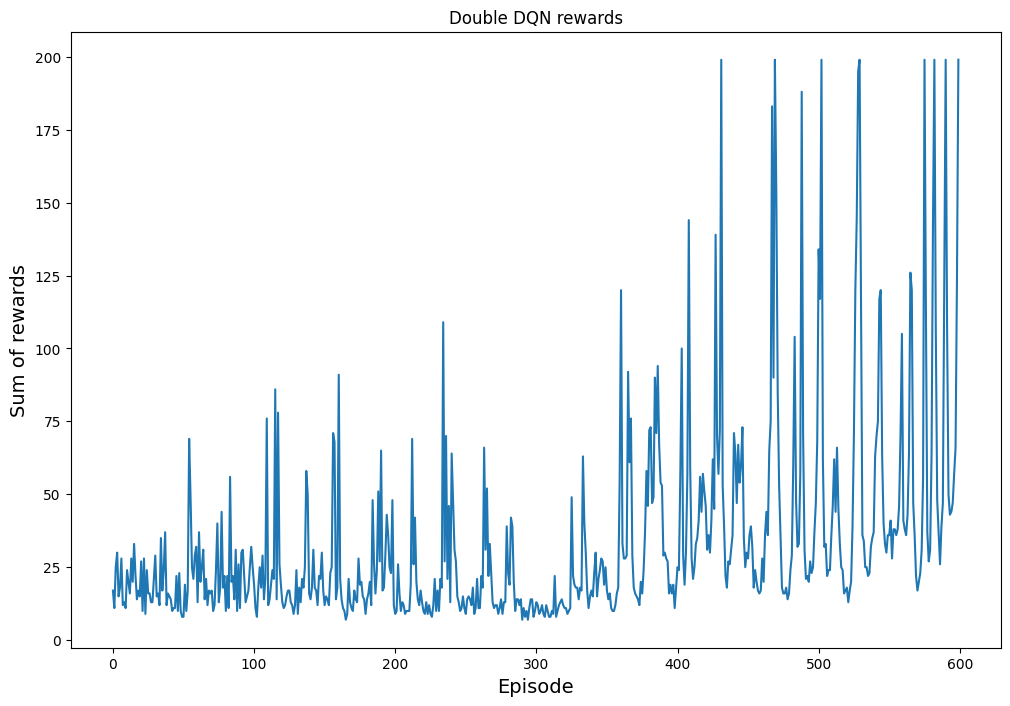

In [35]:
# 에피소드 반복에 따른 시각화

plt.figure(figsize=(12, 8))
plt.plot(rewards)
plt.xlabel("Episode", fontsize=14)
plt.ylabel("Sum of rewards", fontsize=14)
plt.title("Double DQN rewards")
plt.show()

In [ ]:
# DQN 애니메이션 반출
state = env.reset()

frames = []

for step in range(600):
    action = epsilon_greedy_policy(state)
    state, reward, done, info = env.step(action)
    if done:
        break
    img = env.render(mode="rgb_array")
    frames.append(img)

In [39]:
# 코드분할
plot_animation(frames)